In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add



In [35]:
def readtext(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [36]:
captions = readtext('data\captions.txt')


In [37]:
print(type(captions))

<class 'str'>


In [38]:
captions = captions.split("\n")
print(len(captions))

40457


In [39]:
captions.remove(captions[0])

In [40]:
captions[0]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .'

In [41]:
captions[-1]

''

removing last string as it was empty

In [42]:
captions = captions[:-1]
print(len(captions))

40455


Each image has 5 captions.<br>
Creating dictionary to map each image with list of Captions it has.<br>
Key = image_name<br>
value = caption<br>

In [43]:
desc = {}

for c in captions:
    element = c.split(",")
    image_name = element[0].split(".")[0]
    cap = element[1]

    if desc.get(image_name) == None:
        desc[image_name] = []
    desc[image_name].append(cap)


In [53]:
first_key = next(iter(desc))
first_value = desc[first_key]

print(f"First key: {first_key}")
print(f"First value: {first_value}")


First key: 1000268201_693b08cb0e
First value: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [45]:
import cv2


<function matplotlib.pyplot.show(close=None, block=None)>

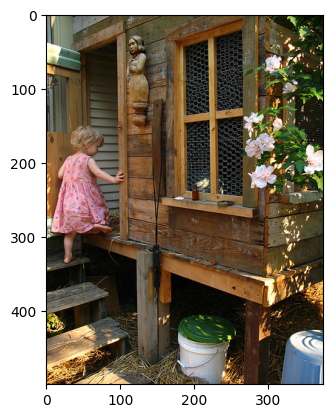

In [57]:
img = cv2.imread("data/Images/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show

DATA CLEANING<br>

Clean data like lowercasing all words removing special tokens(%,$.. etc) eliminating words containing numbers.


In [63]:
def cleandata(data):
    data = data.lower()                 #lowercasing
    data = re.sub("[^a-z]+"," ",data)   #remove punctuations tokens
    data = data.split()
    data = [d for d in data if len(d) > 1] #word length > 1
    data = " ".join(data)
    return data

In [67]:
for key, desclist in desc.items():
    for i in range(len(desclist)):
        desclist[i] = cleandata(desclist[i])

In [71]:
desc['667626_18933d713e'] #checking

['girl is stretched out in shallow water',
 'girl wearing red and multi colored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

In [73]:
with open("data\description.txt","w") as f:
    f.write(str(desc))

In [74]:
import json
#saving in json fromat
f = open("data\description.txt",'r')
descriptions = f.read()
f.close()

json_accept_str = descriptions.replace("'","\"")
descriptions = json.loads(json_accept_str)

Creating Vocabulary

Many words will occur only a few times like 1 or 2 time so if we are creating a predictive model we wouldnt want to have all words present we only want the most likely to occur/common ones. 

In [78]:
vocabulary = set()

for key in descriptions.keys():
    for i in descriptions[key]:
        words = i.split()
        vocabulary.update(words)

print(len(vocabulary))


8257


In [82]:
all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for descs in descriptions[key] for i in descs.split()]

print(len(all_vocab))
print(all_vocab[:20])

357791
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little']


In [83]:
#consider words which occur more than 10 times in the captions

import collections

counter =  collections.Counter(all_vocab)
dicts = dict(counter)

threshold = 10

sorted_dict = sorted(dicts.items(), reverse=True, key = lambda x: x[1])
sorted_dict = [x for x in sorted_dict if x[1]>threshold]
all_vocab = [x[0] for x in sorted_dict]
len(all_vocab)


1800

Preparing the Test and Train Data

In [89]:
f = open("data\Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [90]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]


In [91]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [92]:
f = open("data\Flickr_8k.testImages.txt")
test = f.read()
f.close()

test  = [e.split(".")[0] for e in test.split("\n")[:-1]]
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [95]:
train_desc = {}

for t in train:
    train_desc[t] = []
    for cap in descriptions[t]:
        cap_to_app = "startseq " + cap + " endseq"
        train_desc[t].append(cap_to_app)

train_desc['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

IMAGE PROCESSING

IMAGE -> VECTOR so we can feed it to nueral network

ResNet50 used for not loosing accuracy as model goes deeper and tackle issue of vanishing gradient descent

In [96]:
IMG_PATH = "data\Images"

In [97]:
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 57s 1us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [100]:
model_new = Model(model.input, model.layers[-2].output)

In [105]:
def preprocess(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


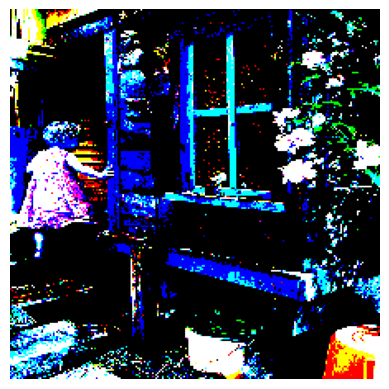

In [106]:
img = preprocess("data/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()


Image encoding

In [107]:
def encode_image(img):
    img = preprocess(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [108]:
encode_image("data/Images/1000268201_693b08cb0e.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0.06536571, 0.16782746, 0.3251849 , ..., 0.0511153 , 0.3281789 ,
       1.0043337 ], dtype=float32)

In [113]:
start = time()

from tqdm.notebook import tqdm

encoding_train = {}

for ix, img_id in tqdm(enumerate(train),total=len(train)):
     
    img = IMG_PATH+"/"+img_id+".jpg".format(train[ix])
    encoding_train[img_id] = encode_image(img)
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Encoding image- 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━

In [123]:
with open("data/encoded_train_imgs.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [120]:
start = time()

encoding_test = {}

for ix, img_id in tqdm(enumerate(test),total=len(test)):
            
    img = IMG_PATH+"/"+img_id+".jpg".format(test[ix])
    encoding_test[img_id] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
Encoding image- 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━

In [121]:
with open("data/encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [127]:
with open("data/encoded_train_imgs.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)



In [128]:
with open("data\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [129]:
#word to index map each unique word in all_vocab to int value and idx to word is vice versa

idx = 1
word_to_indx = {}
indx_to_word = {}

for i in all_vocab:
    word_to_indx[i] = idx
    indx_to_word[idx] = i
    idx += 1


In [131]:
word_to_indx["child"]

40

In [132]:
indx_to_word[40]

'child'

In [133]:
print(len(indx_to_word))

1800


In [134]:
word_to_indx['startseq'] = 1801
word_to_indx['endseq'] = 1802

indx_to_word[1801] = 'startseq'
indx_to_word[1802] = 'endseq'

In [135]:
vocab_size = len(indx_to_word)+1
vocab_size

1803

In [136]:
all_cap_len = []

for key in train_desc.keys():
    for cap in train_desc[key]:
        all_cap_len.append(len(cap.split()))

max_len = max(all_cap_len)
max_len

30

In [184]:
def data_generator(train_desc, encoding_train, word_to_indx, max_len, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key, desc_list in train_desc.items():
            n += 1

            photo = encoding_train[key]

            for desc in desc_list:
                seq = [word_to_indx[word] for word in desc.split() if word in word_to_indx]

                for i in range(1, len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                # Correct yield statement
                yield (np.array(X1), np.array(X2)), np.array(y)  # Tuple of (inputs, outputs)
                X1, X2, y = [], [], []
                n = 0


In [140]:

import requests

url = 'http://nlp.stanford.edu/data/wordvecs/glove.6B.zip'
filename = 'glove.6B.zip'

# Download the file
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)



In [141]:
import zipfile


target_folder = 'data'

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

In [142]:
f = open("data/glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype="float")

    embedding_index[word] = coeff

f.close()

In [143]:
embedding_index['child']

array([ 0.30459 ,  0.40631 , -0.37512 , -1.2075  ,  1.0473  ,  1.579   ,
       -0.15254 , -0.27604 ,  1.0093  ,  0.08583 ,  0.17895 ,  0.26302 ,
        0.2241  , -0.39434 ,  1.4092  , -0.43509 , -0.6516  ,  0.10294 ,
        0.73823 ,  0.20905 , -0.1405  ,  1.1462  , -0.1672  ,  0.5987  ,
        0.31977 , -1.9205  , -0.25067 , -0.94027 ,  0.33703 , -0.20613 ,
        2.6765  ,  0.28159 , -0.37146 , -0.80129 ,  0.30049 ,  0.57209 ,
        0.326   , -0.4331  ,  0.60803 , -0.71701 , -0.68058 ,  0.080862,
        0.40396 ,  0.24926 ,  0.61058 , -0.48516 ,  0.12207 , -1.1695  ,
        0.33096 ,  0.46469 ])

In [144]:
#converting words to vectors 

def get_embedding_output():
    emb_dim = 50
    embedding_output = np.zeros((vocab_size, emb_dim))

    for word, indx in word_to_indx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_output[indx] = embedding_vector

    return embedding_output

embedding_output = get_embedding_output()

In [145]:
embedding_output

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [146]:
embedding_output.shape

(1803, 50)

Feature extraction and Sequence Generation

In [149]:
input_img_feature = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [148]:
#sequence model partial cap

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cp2  = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cp2)


In [150]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


In [168]:
model = Model(inputs=[input_img_feature, input_cap], outputs=outputs)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 50)    │     90,150 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1803)      │    463,371 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,458,225 (5.56 MB)

 Trainable params: 1,368,075 (5.22 MB)

 Non-trainable params: 90,150 (352.15 KB)

In [169]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False
model.compile(loss="categorical_crossentropy", optimizer="adam")


TRAINING ARC!!

In [170]:
epochs = 15
number_pics_per_batch = 3
steps = len(train_desc)//number_pics_per_batch

In [188]:

for i in range(epochs):
    generator = data_generator(train_desc, encoding_train, word_to_indx, max_len, number_pics_per_batch)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('data/model_weights/model_' + str(i) + '.h5')

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 195s 97ms/step - loss: 3.0744


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 183s 92ms/step - loss: 2.9820


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 191s 96ms/step - loss: 2.9078


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 194s 97ms/step - loss: 2.8470


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 196s 98ms/step - loss: 2.7966


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 188s 94ms/step - loss: 2.7563


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 95ms/step - loss: 2.7148


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 191s 95ms/step - loss: 2.6874


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 186s 93ms/step - loss: 2.6580


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 191s 95ms/step - loss: 2.6313


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 96ms/step - loss: 2.6093


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 188s 94ms/step - loss: 2.5911


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 94ms/step - loss: 2.5717


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 186s 93ms/step - loss: 2.5544


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 186s 93ms/step - loss: 2.5417


In [195]:
def predict_cap(photo):
    in_text = "startseq"

    for i in range(max_len):
        sequence = [word_to_indx[w] for w in in_text.split() if w in word_to_indx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = indx_to_word[ypred]
        in_text +=  ' ' + word

        if word == 'endseq':
            break

    
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption


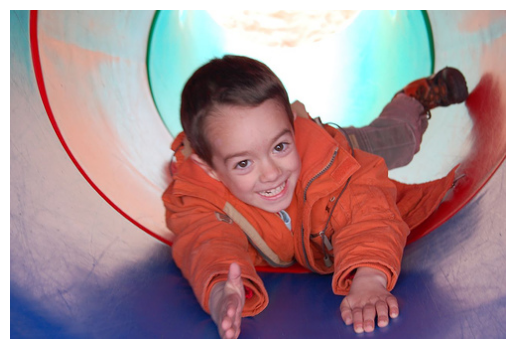

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
child in tunnel tunnel


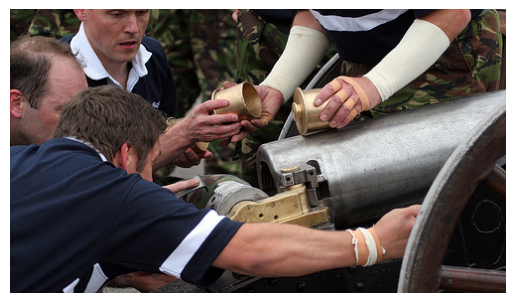

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
man in camouflage and black hat is sitting on bench


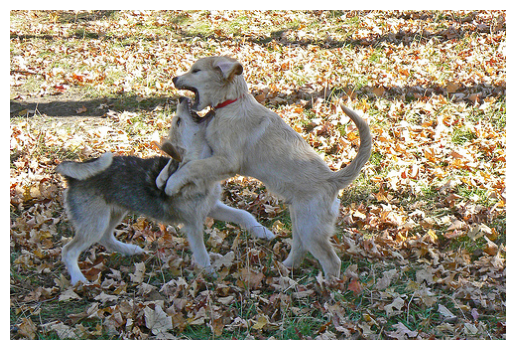

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
two dogs are running in the grass


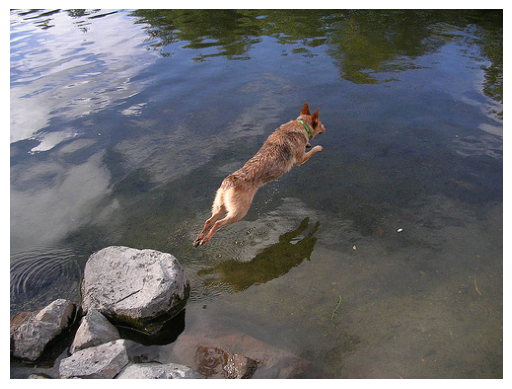

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
dog swims through the water


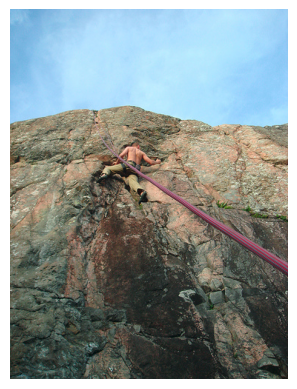

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
man is climbing up rock face


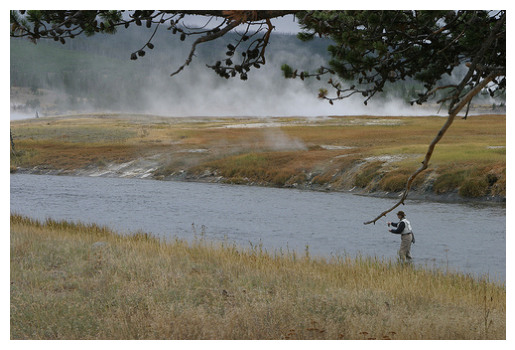

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
dog is running through the water


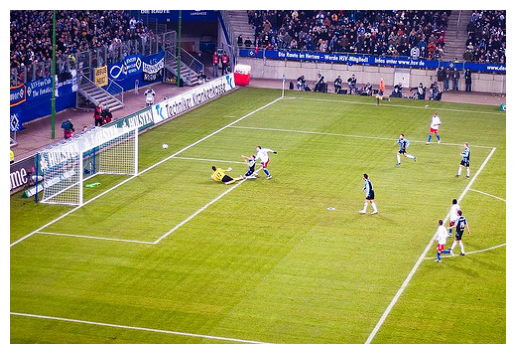

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
cricket player is following the game


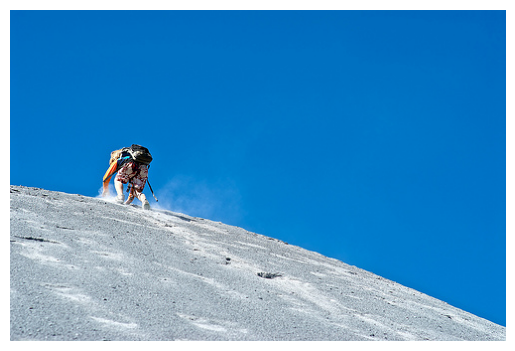

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
man in red shirt and backpack is climbing rock face


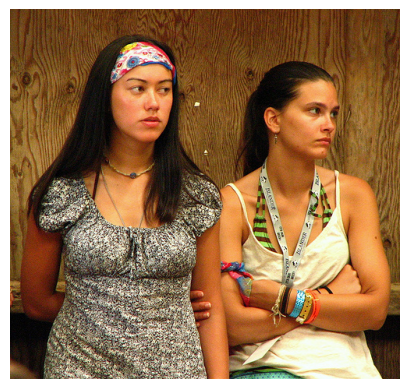

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
three people are posing for picture


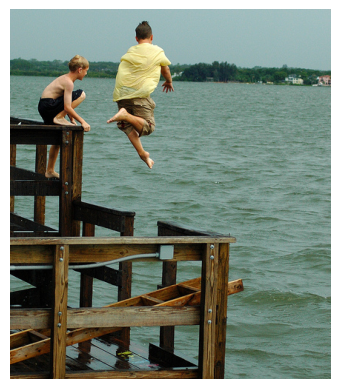

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
man and dog are jumping into swimming pool


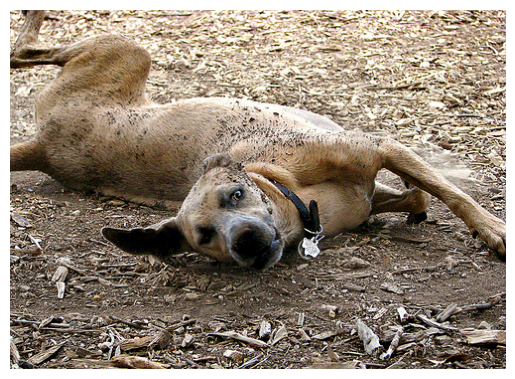

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
two dogs are running on the sand


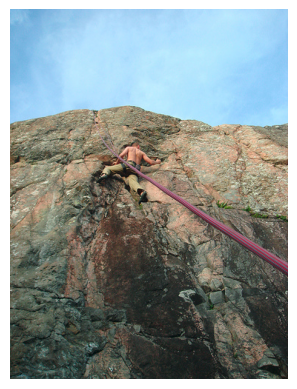

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
man is climbing up rock face


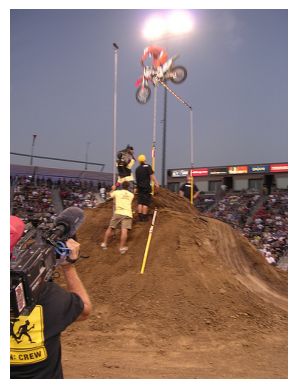

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
man in red shirt and black pants is leading on the beach


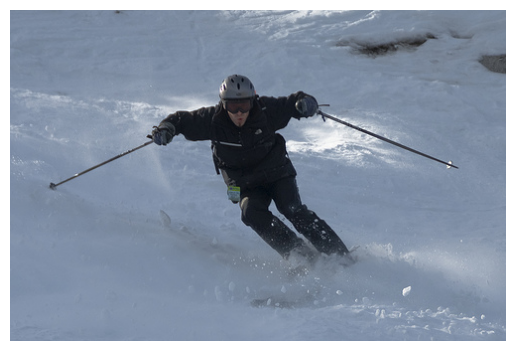

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
man in red coat skiing


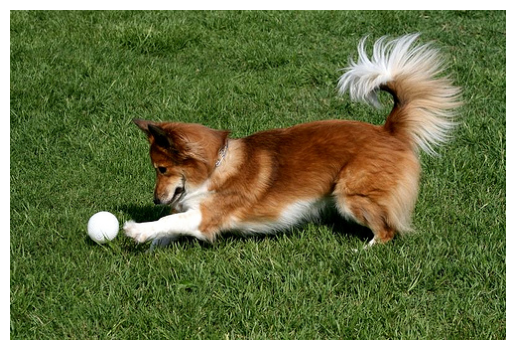

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
brown dog is running on the grass


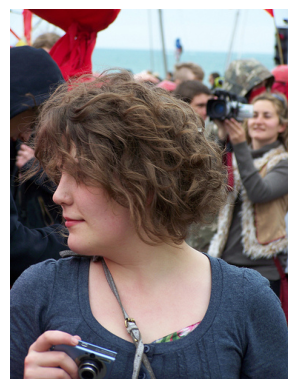

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
man with camera and looks at the camera


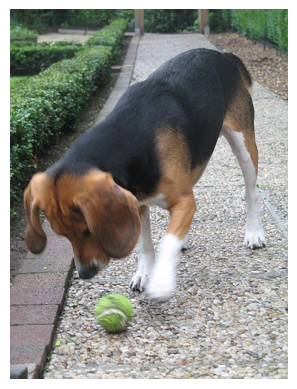

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
brown and white dog is jumping up on the grass


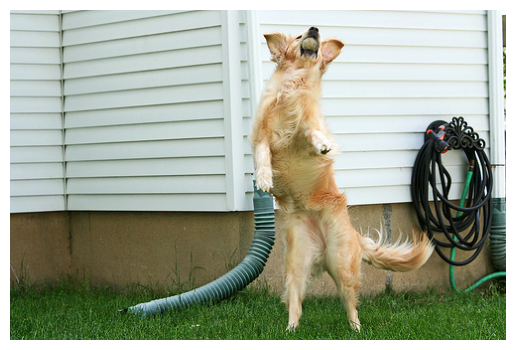

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
dog catches tennis ball in its mouth


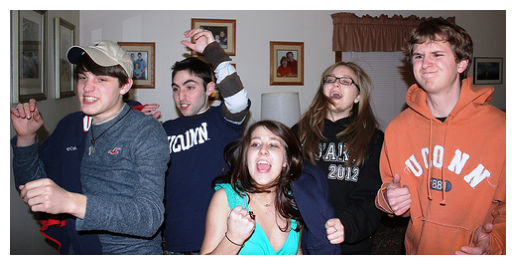

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
three people are standing in front of wall


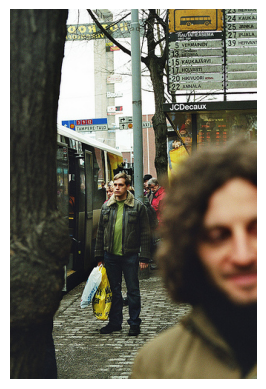

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
man in red jacket and tie is sitting on bench


In [197]:
for i in range(20):
    rn =  np.random.randint(0, 1000)

    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH +"/" +img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_cap(photo)
    print(caption)
